# Foraging toolkit demo - communicating foragers, Part II (Inference)

## Outline

* [Introduction](#introduction)
* [Load simulation data](#load-simulation-data)
* [Derived quantities](#derived-quantities)
  * [Visualization](#visualization)
* [Inference](#inference)

## Introduction

In a multi-agent context, communication of information between foragers is an important
feature of group-level behavior, as is the impact of different environmental conditions. We thus explore how one
might infer to what extent agents communicate with each other to facilitate foraging. We ask whether the
benefit of communicating information would be different for different environments, using multiple simulations
with a range of communication-related hyper-parameters. In environments where food is highly clustered, it
takes longer for birds to find food, but in all environments, using information communicated from other birds
improves foraging success. The Bayesian inference methods are able to correctly compare the extent to which
simulated agents communicate about the locations of the rewards.

The communicating foragers demo is divided into two notebooks:
1.  Simulation [`communicators_simulations.ipynb`](./communicators_simulations.ipynb) - run/read this prior to continuing further 
2. Inference (this one)

The users are advised to read through the demo notebooks in  [`docs/foraging/random-hungry-followers`](../random-hungry-followers/) folder to get familiarized with the foraging toolkit, and, specifically, computing predictors and running inference, which is the focus of this part of the demo.

The main reference is [1], in particular Fig.3.

---

[1] R. Urbaniak, M. Xie, and E. Mackevicius, “Linking cognitive strategy, neural mechanism, and movement statistics in group foraging behaviors,” Sci Rep, vol. 14, no. 1, p. 21770, Sep. 2024, [doi: 10.1038/s41598-024-71931-0.](https://www.nature.com/articles/s41598-024-71931-0)

In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time

import dill
import pandas as pd
import plotly.io as pio

import collab2.foraging.toolkit as ft
from collab2.foraging.toolkit import dataObject
from collab2.utils import find_repo_root

pio.renderers.default = "notebook"

root = find_repo_root()

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
# smoke_test = True
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()

## Load simulation data

We will analyze the two runs in the `communicators_strong` folder, corresponding to `c_trust=0` (suffix $0$ below) and `c_trust=0.6` (suffix $6$ below). After loading the simulated data, we further make some data wrangling to create the foraging toolkit underlying data structure of type `ft.dataObject`, which is further passed to the predictor computation routines. We also compute the _local windows_ (see `random_foragers.ipynb` [demo notebook](../random-hungry-followers/random_foragers.ipynb)). We save the results on disk to speed up further experimentation.

In [2]:
sim_params = pd.read_csv(
    os.path.join(
        root, "data/foraging/communicators/communicators_strong/metadataDF.csv"
    ),
    index_col=0,
)

sim_params.head()

c_trust  sight_radius  reward_patch_dim  sim index
0      0.0             6                 2          0
1      0.6             6                 2          1

In [3]:
communicators_object_path0 = "communicators0.pkl"
communicators_object_path6 = "communicators6.pkl"

local_windows_kwargs = {
    "window_size": 10,
    "sampling_fraction": 1,
    "skip_incomplete_frames": False,
}

if not os.path.exists(communicators_object_path0):

    home_dir = os.path.join(root, "data/foraging/communicators/communicators_strong")

    sim0_folder = "sim0_run0"
    sim6_folder = "sim1_run0"

    sim0_dir = os.path.join(home_dir, sim0_folder)
    sim6_dir = os.path.join(home_dir, sim6_folder)

    bird0 = pd.read_csv(os.path.join(sim0_dir, "foragerlocsDF.csv"), index_col=0)

    foragerlocsDF0 = pd.read_csv(
        os.path.join(sim0_dir, "foragerlocsDF.csv"), index_col=0
    )
    foragerlocsDF6 = pd.read_csv(
        os.path.join(sim6_dir, "foragerlocsDF.csv"), index_col=0
    )

    rewardlocsDF0 = pd.read_csv(os.path.join(sim0_dir, "rewardlocsDF.csv"), index_col=0)
    rewardlocsDF6 = pd.read_csv(os.path.join(sim6_dir, "rewardlocsDF.csv"), index_col=0)

    # drop last frame to make the two dataframes the same length
    last = foragerlocsDF0["time"].unique()[-1]
    foragerlocsDF0 = foragerlocsDF0.drop(
        foragerlocsDF0[foragerlocsDF0["time"] == last].index
    )
    foragerlocsDF6 = foragerlocsDF6.drop(
        foragerlocsDF6[foragerlocsDF6["time"] == last].index
    )

    assert all(rewardlocsDF0["time"].unique() == foragerlocsDF0["time"].unique())
    assert all(rewardlocsDF6["time"].unique() == foragerlocsDF6["time"].unique())

    def shift_to_start_with_0s(df):
        df["time"] = df["time"] - df["time"].min()
        df["forager"] = df["forager"] - df["forager"].min()
        return df

    foragerlocsDF0 = shift_to_start_with_0s(foragerlocsDF0)
    foragerlocsDF6 = shift_to_start_with_0s(foragerlocsDF6)

    rewardlocsDF0["time"] = rewardlocsDF0["time"] - 1
    rewardlocsDF6["time"] = rewardlocsDF6["time"] - 1

    communicators0 = dataObject(foragersDF=foragerlocsDF0, rewardsDF=rewardlocsDF0)
    communicators6 = dataObject(foragersDF=foragerlocsDF6, rewardsDF=rewardlocsDF6)

    communicators0.foragersDF.head(), communicators6.foragersDF.head()

    for foragers_object in [communicators0, communicators6]:
        foragers_object.local_windows_kwargs = local_windows_kwargs
        foragers_object.local_windows = ft.generate_local_windows(foragers_object)

    with open(communicators_object_path0, "wb") as f:
        dill.dump(communicators0, f)

    with open(communicators_object_path6, "wb") as f:
        dill.dump(communicators6, f)

else:
    print("Loading communicators objects from disk...")
    with open(communicators_object_path0, "rb") as f:
        communicators0 = dill.load(f)

    with open(communicators_object_path6, "rb") as f:
        communicators6 = dill.load(f)


assert communicators0.grid_size == communicators6.grid_size

Loading communicators objects from disk...


## Derived quantities

Please consult the [corresponding section in the `random_foragers.ipynb` notebook](../random-hungry-followers/random_foragers.ipynb#derived-quantities) for explanation of derived quantities (predictors and scores).

Here in addition to the three predictors described there, we will use a new `communication` predictor.

In [4]:
ft.get_list_of_predictors()

['access', 'communication', 'food', 'pairwiseCopying', 'proximity', 'vicsek']

In [5]:
help(ft.generate_communication_predictor)

Help on function generate_communication_predictor in module collab2.foraging.toolkit.communication:

generate_communication_predictor(foragers_object: collab2.foraging.toolkit.utils.dataObject, predictor_name: str)
    Generates communication-based predictors for a group of foragers. When a forager 
    is in the vicinity of food, it can communicate this information with the other
    foragers. The predictor value is proportional to the proximity of the communicating
    partner, but only if that partner is close to a food source.
    The predictor can be customized by providing a custom communication function
    (default: exponential decay) and/or a custom interaction function (default: closeness to food).
    
    
    Arguments:
    :param foragers_object: A data object containing information about the foragers, including their positions,
                            trajectories, and local windows. Such objects can be generated using `object_from_data`.
    :param predictor_name: T

In other words we have
$$
f_{\text{comm}}^{(i)}(x,y,t) = \sum_{j \in \mathrm{NB}(i,t)}\operatorname{comm}\left(\operatorname{dist}(forager_j(t), (x,y))\right),\qquad (x,y)\in W(i,t),
$$
where
* $W(i,t)$ is the local window,
* $\operatorname{comm}$ is the communication function (default: $\operatorname{comm}(d)=\exp(-\alpha*d)$), and
* $\mathrm{NB}(i,t)$ is the set of foragers interacting with $i$ at time $t$, where in addition, there exists $r$ such that $\operatorname{dist}(forager_j(t),reward_r(t))\leqslant \text{finders\_tolerance}$.

Compare this with the $\text{proximity}$ predictor in [`random_foragers.ipynb`](../random-hungry-followers/random_foragers.ipynb#computation).

The other predictors and the $\text{nextStep}$ score are described in detail in [`random_foragers.ipynb`](../random-hungry-followers/random_foragers.ipynb) as well.

Here we compute the derived quantities for the two simulations. 

In [6]:
communicators_derived_path0 = "communicators_derivedDF_0.pkl"
communicators_derived_path6 = "communicators_derivedDF_6.pkl"

if not os.path.exists(communicators_derived_path0):

    interaction_constraint_params = {
        "finders_tolerance": 8,
    }

    predictor_kwargs = {
        "food": {
            "decay_factor": 0.5,
        },
        "communication": {
            "interaction_length": 15,
            "interaction_constraint_params": interaction_constraint_params,
        },
        "access": {
            "decay_factor": 0.2,
        },
        "proximity": {
            "interaction_length": communicators0.grid_size / 3,
            "interaction_constraint": None,
            "interaction_constraint_params": None,
            "repulsion_radius": 1.5,
            "optimal_distance": 4,
            "proximity_decay": 1,
        },
    }

    score_kwargs = {
        "nextStep_linear": {"nonlinearity_exponent": 1},
        "nextStep_sublinear": {"nonlinearity_exponent": 0.5},
    }

    derivedDF_0 = ft.derive_predictors_and_scores(
        communicators0,
        local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=True,
    )

    derivedDF_6 = ft.derive_predictors_and_scores(
        communicators6,
        local_windows_kwargs,
        predictor_kwargs=predictor_kwargs,
        score_kwargs=score_kwargs,
        dropna=True,
        add_scaled_values=True,
    )

    with open(communicators_derived_path0, "wb") as f:
        dill.dump(derivedDF_0, f)

    with open(communicators_derived_path6, "wb") as f:
        dill.dump(derivedDF_6, f)

    # the objects themselves have been updated, need to save them
    with open(communicators_object_path0, "wb") as f:
        dill.dump(communicators0, f)

    with open(communicators_object_path6, "wb") as f:
        dill.dump(communicators6, f)

else:
    print("Loading derivedDF from disk...")
    with open(communicators_derived_path0, "rb") as f:
        derivedDF_0 = dill.load(f)

    with open(communicators_derived_path6, "rb") as f:
        derivedDF_6 = dill.load(f)

display(derivedDF_0.head())
display(derivedDF_6.head())

Loading derivedDF from disk...


x   y  distance_to_forager  time  forager      food  communication  \
0  7  21            10.000000     0        0  0.056661       0.000340   
1  8  17             9.848858     0        0  0.204795       0.001569   
2  8  18             9.486833     0        0  0.147257       0.001210   
3  8  19             9.219544     0        0  0.101767       0.000916   
4  8  20             9.055385     0        0  0.068356       0.000683   

     access  proximity  distance_to_next_step  nextStep_linear  \
0  0.135335   0.770906              11.045361         0.031258   
1  0.139489   0.223198              10.440307         0.084325   
2  0.149963   0.470750              10.198039         0.105573   
3  0.158198   0.809017              10.049876         0.118568   
4  0.163478   0.956321              10.000000         0.122942   

   nextStep_sublinear  food_scaled  communication_scaled  access_scaled  \
0            0.015753     0.056618              0.000340       0.000000   
1            0.043091     0.204759              0.001569       0.004804   
2            0.054258     0.147218              0.001210       0.016917   
3            0.061154     0.101726              0.000916       0.026441   
4            0.063486     0.068314              0.000683       0.032548   

   proximity_scaled  nextStep_linear_scaled  nextStep_sublinear_scaled  
0          0.885453                0.031258                   0.015753  
1          0.611599                0.084325                   0.043091  
2          0.735375                0.105573                   0.054258  
3          0.904508                0.118568                   0.061154  
4          0.978160                0.122942                   0.063486

x  y  distance_to_forager  time  forager      food  communication  \
0  10  1            10.000000     0        0  0.415940       0.108346   
1  11  0             9.055385     0        0  0.256067       0.096656   
2  11  1             9.000000     0        0  0.256260       0.149011   
3  11  2             9.055385     0        0  0.224478       0.219709   
4  11  3             9.219544     0        0  0.176445       0.295398   

     access  proximity  distance_to_next_step  nextStep_linear  \
0  0.135335   0.516062              12.041595         0.000000   
1  0.163478   0.540253              11.180340         0.071523   
2  0.165299   0.542603              11.045361         0.082733   
3  0.163478   0.417474              11.000000         0.086500   
4  0.158198   0.256588              11.045361         0.082733   

   nextStep_sublinear  food_scaled  communication_scaled  access_scaled  \
0            0.000000     0.415913              0.108346       0.000000   
1            0.036425     0.256034              0.096656       0.032548   
2            0.042259     0.256226              0.149011       0.034653   
3            0.044228     0.224442              0.219709       0.032548   
4            0.042259     0.176408              0.295398       0.026441   

   proximity_scaled  nextStep_linear_scaled  nextStep_sublinear_scaled  
0          0.758031                0.000000                   0.000000  
1          0.770126                0.071523                   0.036425  
2          0.771301                0.082733                   0.042259  
3          0.708737                0.086500                   0.044228  
4          0.628294                0.082733                   0.042259

### Visualization

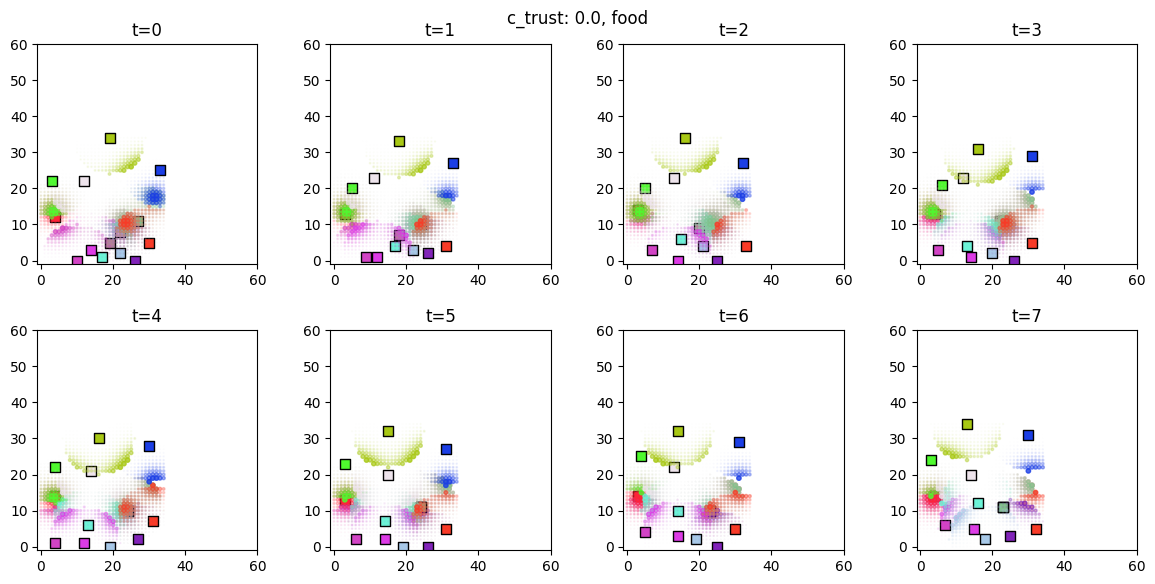

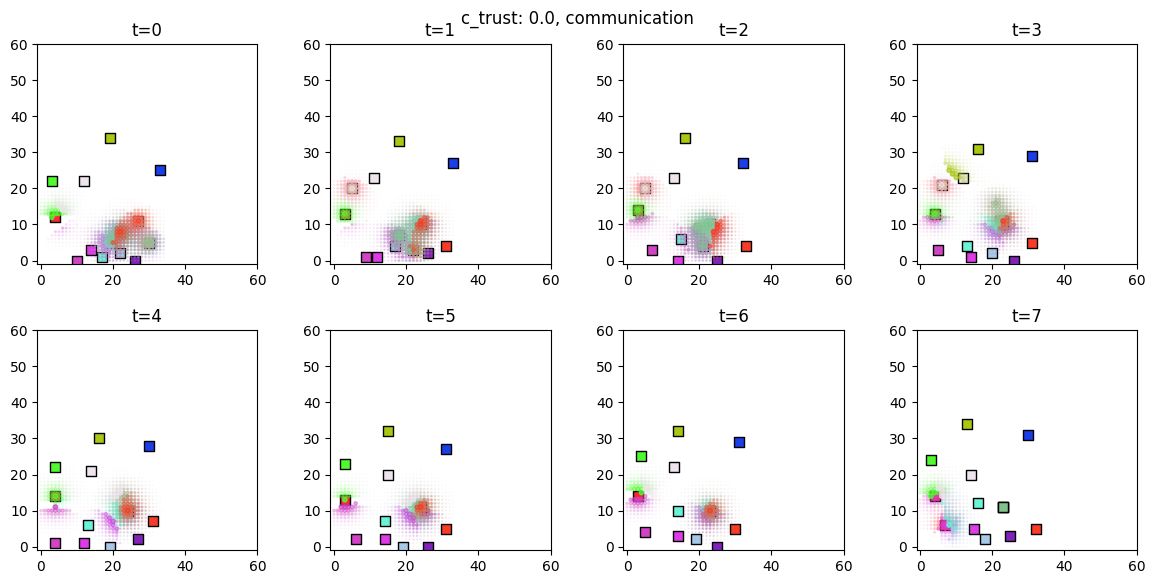

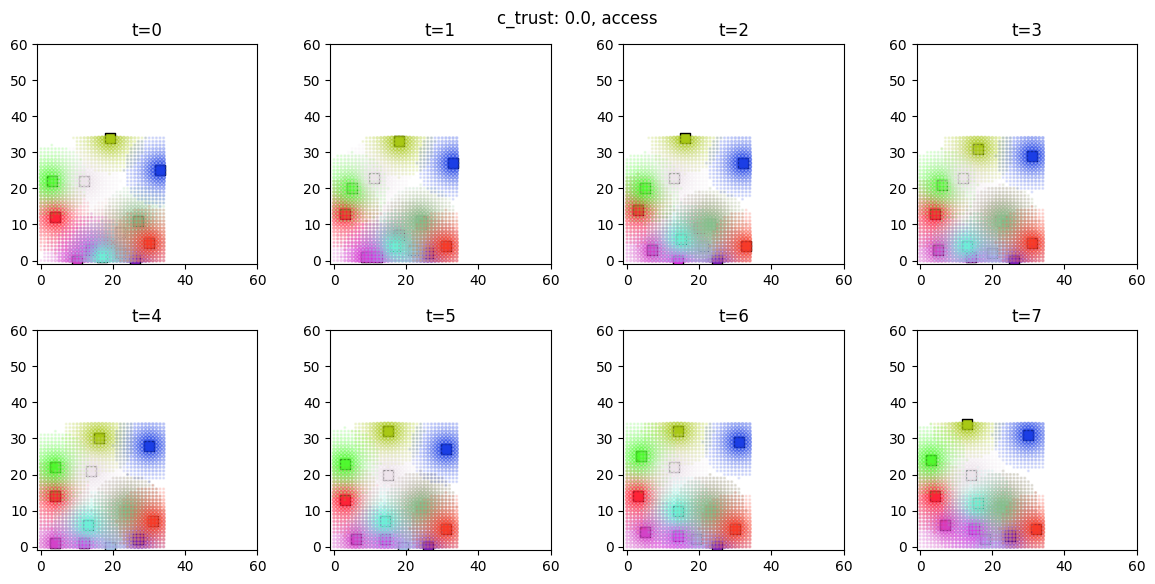

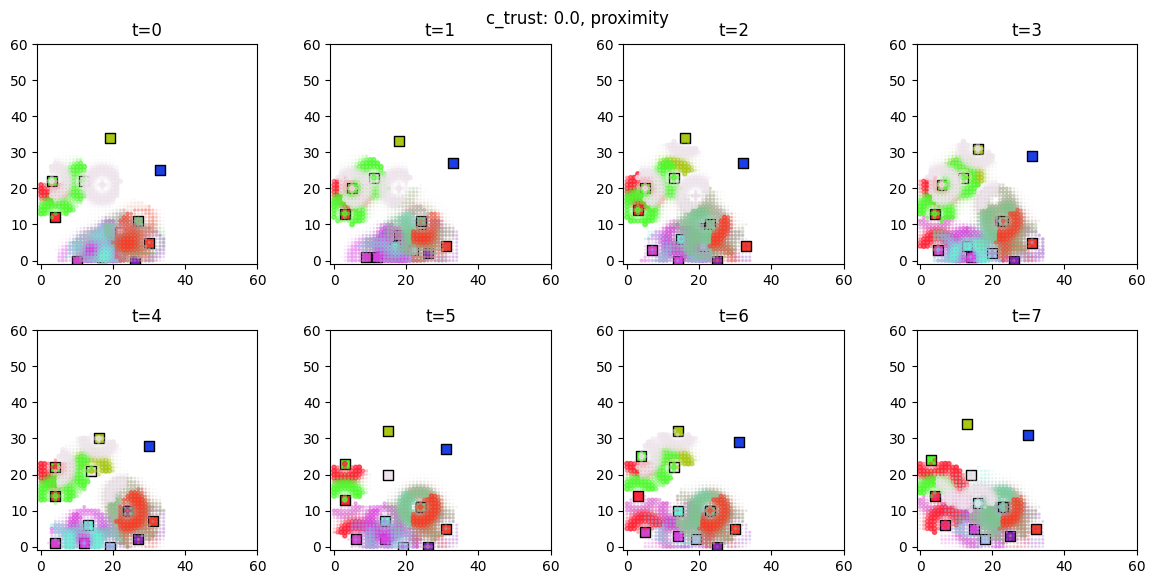

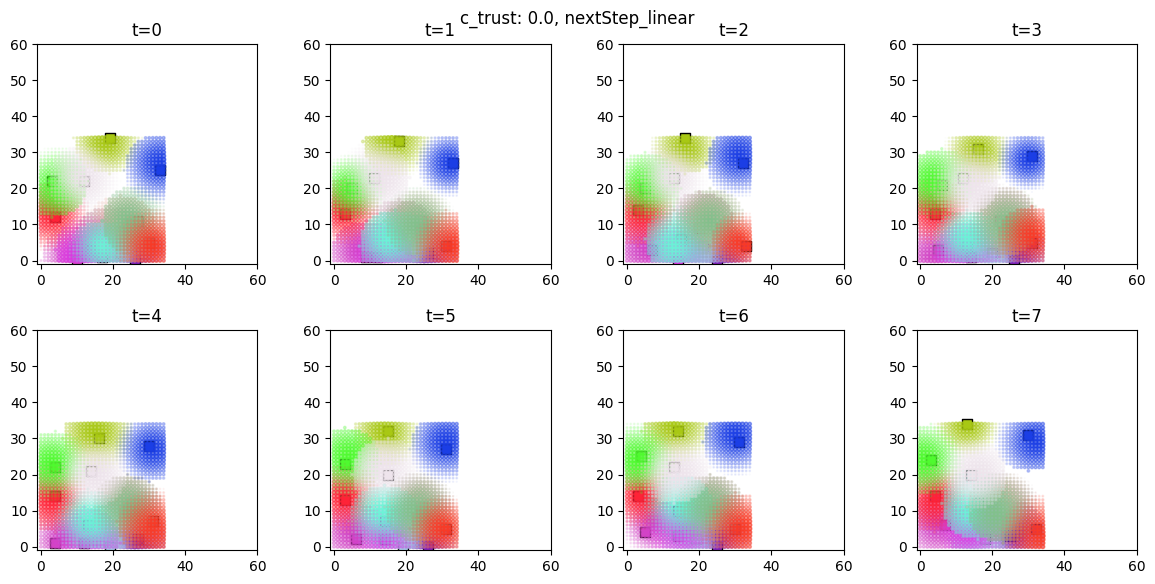

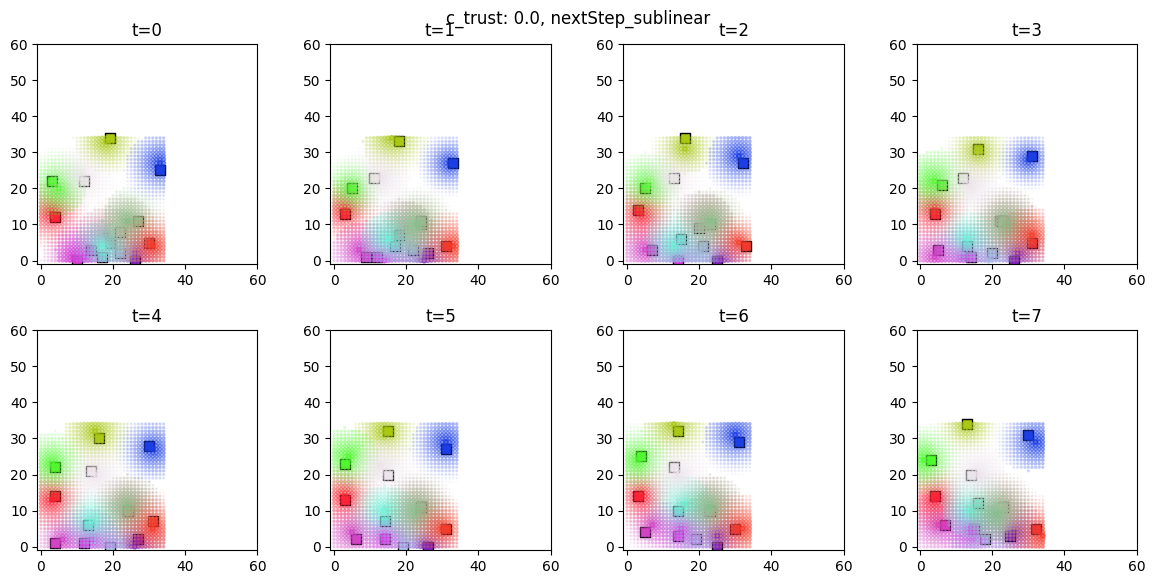

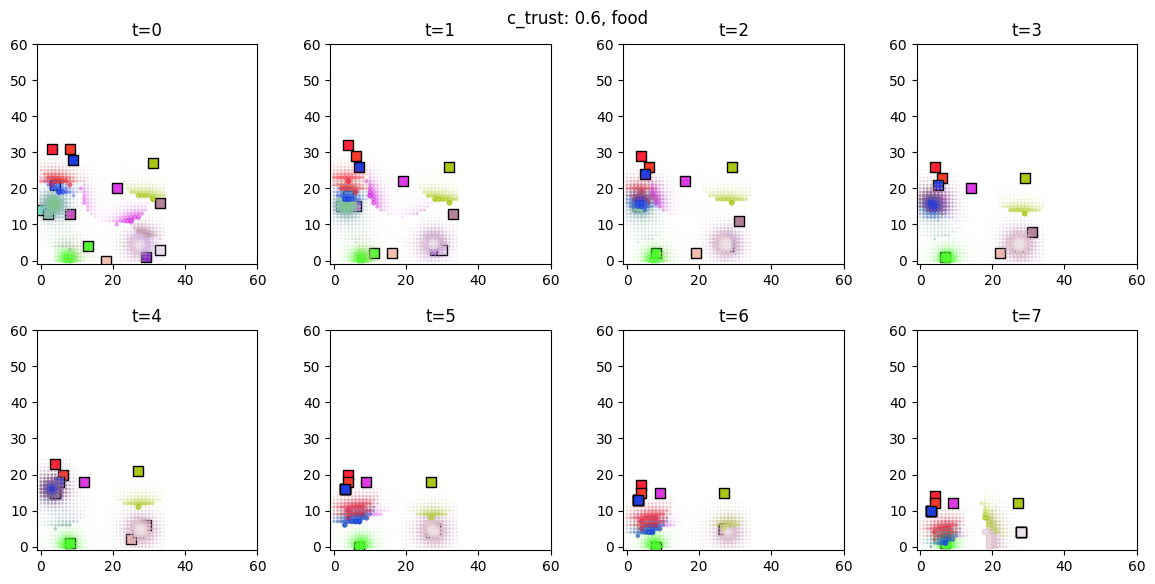

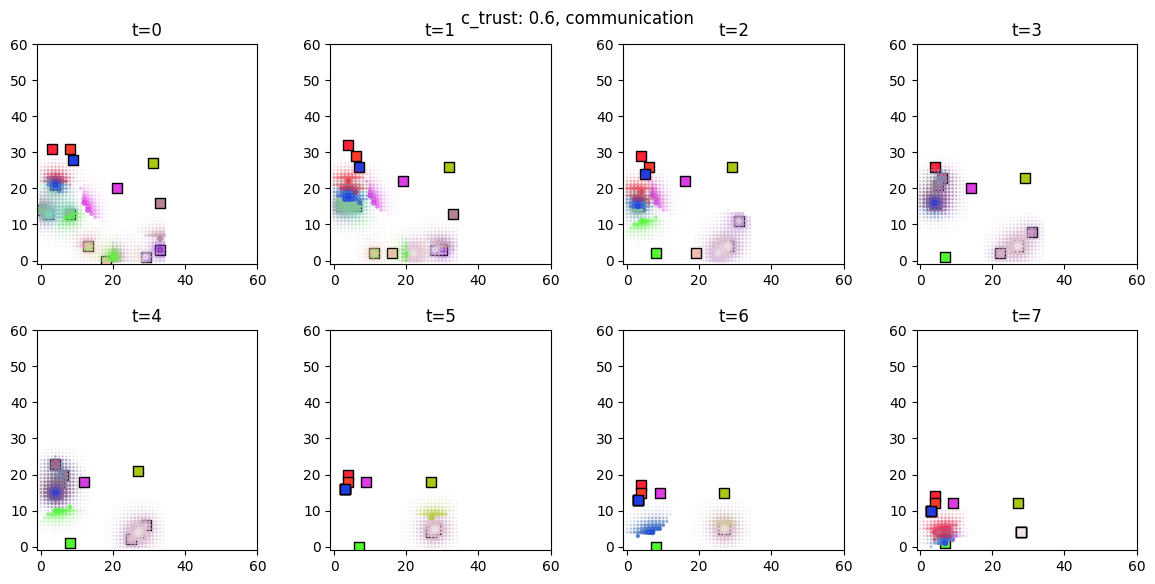

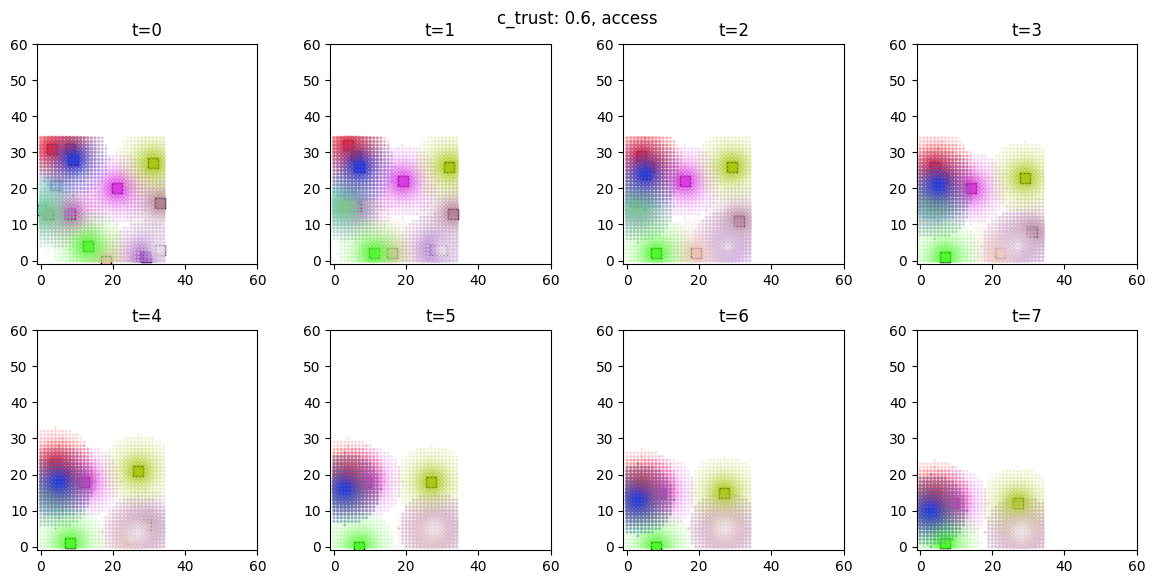

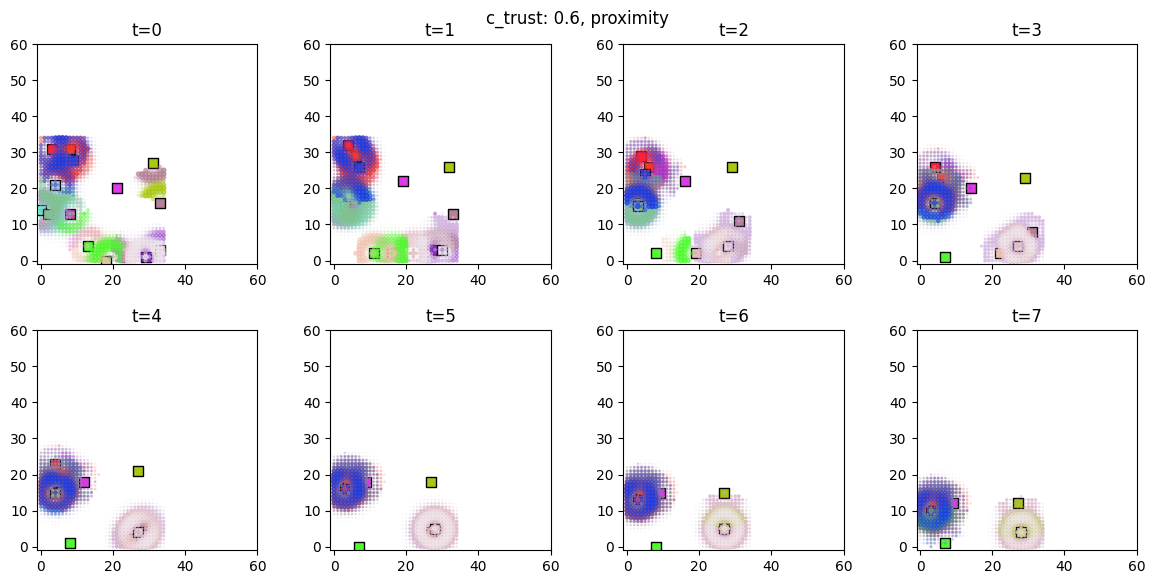

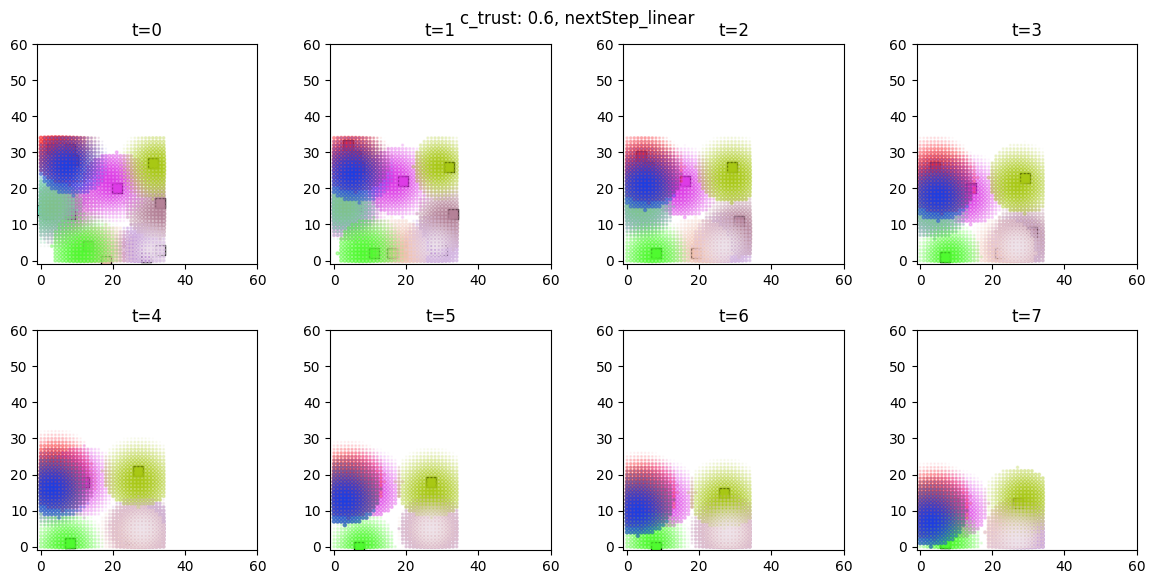

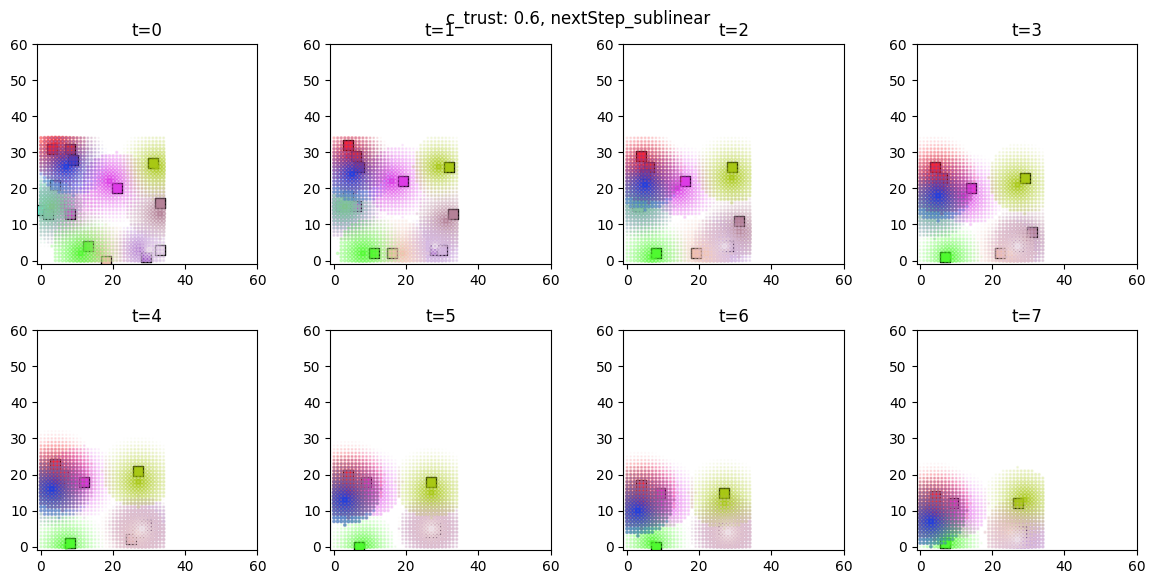

In [7]:
import matplotlib.pyplot as plt

for i, sim in enumerate([communicators0, communicators6]):
    for derived_quantity_name in sim.derived_quantities.keys():
        ft.plot_predictor(
            sim.foragers,
            sim.derived_quantities[derived_quantity_name],
            predictor_name=derived_quantity_name,
            time=range(min(8, num_frames)),
            grid_size=60,
            size_multiplier=10,
            random_state=99,
            forager_position_indices=list(range(1, 15)),
            forager_predictor_indices=list(range(1, 15)),
        )
        plt.suptitle(f"c_trust: {sim_params.iloc[i].c_trust}, {derived_quantity_name}")
        plt.show()

## Inference


We start by defining the predictors and outcomes for inference.

In [8]:
predictors = ["proximity_scaled", "food_scaled", "communication_scaled"]
outcome_vars = ["nextStep_sublinear"]

### Non-communicating foragers

2024-10-08 22:44:11,632 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 1627882.1250
[iteration 0050] loss: 1217859.3750
[iteration 0100] loss: 1216909.1250
[iteration 0150] loss: 1200492.5000
[iteration 0200] loss: 1185682.8750
[iteration 0250] loss: 1185634.8750
[iteration 0300] loss: 1184147.5000
[iteration 0350] loss: 1200397.7500
[iteration 0400] loss: 1182929.7500
[iteration 0450] loss: 1183921.7500
[iteration 0500] loss: 1183231.0000
[iteration 0550] loss: 1184957.3750
[iteration 0600] loss: 1183315.7500
[iteration 0650] loss: 1184374.3750
[iteration 0700] loss: 1182647.8750
[iteration 0750] loss: 1181768.5000
[iteration 0800] loss: 1181660.8750
[iteration 0850] loss: 1182278.8750
[iteration 0900] loss: 1181972.1250
[iteration 0950] loss: 1181667.7500
[iteration 1000] loss: 1183999.5000
[iteration 1050] loss: 1181987.0000
[iteration 1100] loss: 1181680.8750
[iteration 1150] loss: 1182490.0000
[iteration 1200] loss: 1181988.8750
[iteration 1250] loss: 1181961.7500
[iteration 1300] loss: 1182186.0000
[iteration 1350] loss: 11819

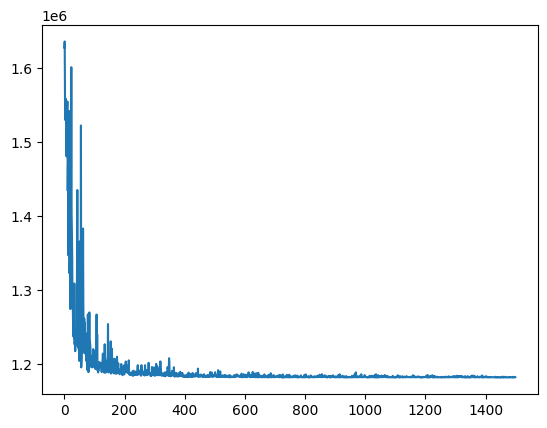

2024-10-08 22:44:22,198 - SVI inference completed in 10.57 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_communication_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_scaled_nextStep_sublinear_sigma', 'weight_continuous_food_scaled_nextStep_sublinear_sigma', 'weight_continuous_communication_scaled_nextStep_sublinear_sigma', 'proximity_scaled', 'food_scaled', 'communication_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_communication_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_sublinear
       mean      std        5%       25%       50%       75%       95%
0  0.181359  0.01447  0.158447  0.171862  0.181596  0.190467  0.205208 

Site: weight_continuous_food_scaled_nextStep_sublinear
       mean   

In [9]:
# prepare the training data
predictor_tensors_0, outcome_tensor_0 = ft.prep_data_for_inference(
    communicators0, predictors, outcome_vars
)

# construct Pyro model
model_sigmavar_0 = ft.HeteroskedasticLinear(predictor_tensors_0, outcome_tensor_0)

# runs SVI to approximate the posterior and samples from it
results_0 = ft.get_samples(
    model=model_sigmavar_0,
    predictors=predictor_tensors_0,
    outcome=outcome_tensor_0,
    num_svi_iters=1500,
    num_samples=1000,
)

selected_sites = [
    key
    for key in results_0["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]
selected_samples = {key: results_0["samples"][key] for key in selected_sites}

ft.plot_coefs(
    selected_samples,
    "Non-communicating foragers",
    nbins=120,
    ann_start_y=160,
    ann_break_y=50,
)

### Communicating foragers

2024-10-08 22:44:24,283 - Starting SVI inference with 1500 iterations.


[iteration 0001] loss: 1732074.6250
[iteration 0050] loss: 1210636.3750
[iteration 0100] loss: 1154179.1250
[iteration 0150] loss: 1168374.0000
[iteration 0200] loss: 1163188.0000
[iteration 0250] loss: 1146200.5000
[iteration 0300] loss: 1146106.8750
[iteration 0350] loss: 1144905.3750
[iteration 0400] loss: 1147659.1250
[iteration 0450] loss: 1145462.5000
[iteration 0500] loss: 1145838.2500
[iteration 0550] loss: 1143546.2500
[iteration 0600] loss: 1142605.2500
[iteration 0650] loss: 1148262.5000
[iteration 0700] loss: 1142014.7500
[iteration 0750] loss: 1143176.2500
[iteration 0800] loss: 1145304.5000
[iteration 0850] loss: 1142033.0000
[iteration 0900] loss: 1142400.5000
[iteration 0950] loss: 1143906.8750
[iteration 1000] loss: 1141571.1250
[iteration 1050] loss: 1141978.3750
[iteration 1100] loss: 1142888.2500
[iteration 1150] loss: 1141725.8750
[iteration 1200] loss: 1142160.7500
[iteration 1250] loss: 1142601.3750
[iteration 1300] loss: 1141984.0000
[iteration 1350] loss: 11414

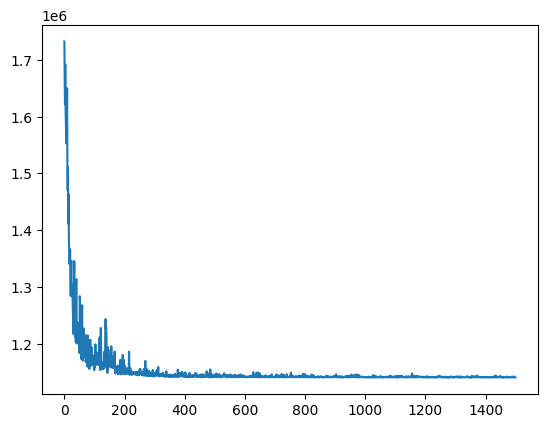

2024-10-08 22:44:33,984 - SVI inference completed in 9.70 seconds.


dict_keys(['bias_continuous_nextStep_sublinear', 'weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_communication_scaled_nextStep_sublinear', 'bias_continuous_nextStep_sublinear_sigma', 'weight_continuous_proximity_scaled_nextStep_sublinear_sigma', 'weight_continuous_food_scaled_nextStep_sublinear_sigma', 'weight_continuous_communication_scaled_nextStep_sublinear_sigma', 'proximity_scaled', 'food_scaled', 'communication_scaled', 'nextStep_sublinear'])
['weight_continuous_proximity_scaled_nextStep_sublinear', 'weight_continuous_food_scaled_nextStep_sublinear', 'weight_continuous_communication_scaled_nextStep_sublinear']
Coefficient marginals:
Site: weight_continuous_proximity_scaled_nextStep_sublinear
       mean       std        5%       25%       50%       75%       95%
0  0.410013  0.012048  0.391142  0.401976  0.409406  0.418229  0.429875 

Site: weight_continuous_food_scaled_nextStep_sublinear
       mean 

In [10]:
predictor_tensors_6, outcome_tensor_6 = ft.prep_data_for_inference(
    communicators6, predictors, outcome_vars
)

model_sigmavar_6 = ft.HeteroskedasticLinear(predictor_tensors_6, outcome_tensor_6)

results_6 = ft.get_samples(
    model=model_sigmavar_6,
    predictors=predictor_tensors_6,
    outcome=outcome_tensor_6,
    num_svi_iters=1500,
    num_samples=1000,
)

selected_sites = [
    key
    for key in results_6["samples"].keys()
    if key.startswith("weight") and not key.endswith("sigma")
]

selected_samples = {key: results_6["samples"][key] for key in selected_sites}

ft.plot_coefs(
    selected_samples,
    "Communicating foragers",
    nbins=120,
    ann_start_y=160,
    ann_break_y=50,
)